In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os

def plot_images(img_list):
    for img in img_list:
        plt.figure(figsize=(10,10))
        plt.imshow(img, 'gray')
        plt.show()

def print_info(data):
    print('Shape: {}'.format(data.shape))
    print('dtype: {}'.format(data.dtype))
    print('Min: {}'.format(data.min()))    
    print('Min: {}'.format(data.max()))    
    print('Mean: {}'.format(data.mean()))    

In [3]:
train_path = '../datasets/EM/train'
test_path = '../datasets/EM/test'
drawn_test_path = './data_example/drawn_test'

train_filenames = sorted([os.path.join(filename) for filename in os.listdir(train_path)])
test_filenames = sorted([os.path.join(filename) for filename in os.listdir(test_path)])
drawn_test_filenames = sorted([os.path.join(filename) for filename in os.listdir(drawn_test_path)])

print(len(train_filenames))
print(len(test_filenames))
print(len(drawn_test_filenames))

100
100
5


# See one image

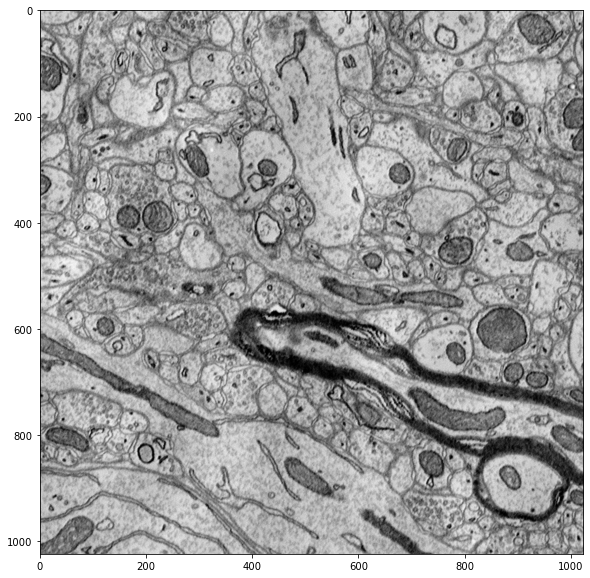

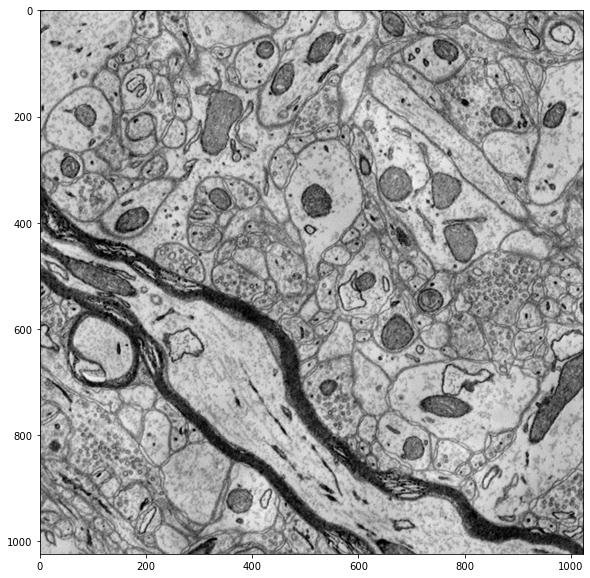

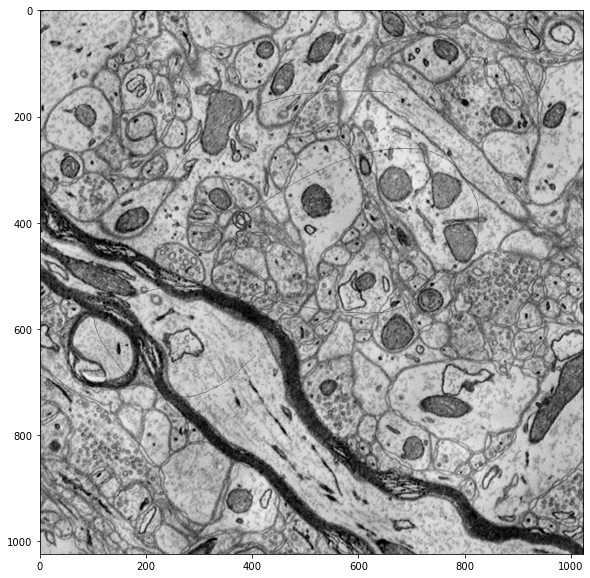

Shape: (1024, 1024)
dtype: float32
Min: 0.0
Min: 1.0
Mean: 0.583771824836731


In [38]:
from src.datasets import read_image
hr_img = read_image(os.path.join(train_path, train_filenames[0]))
test_img = read_image(os.path.join(test_path, test_filenames[0]))
drawn_test_img = read_image(os.path.join(drawn_test_path, drawn_test_filenames[0]))

plot_images([hr_img, lr_img, drawn_lr_img ])
print_info(drawn_lr_img)

# Test `prepare_data`

X_train
Shape: (1600, 128, 128, 1)
dtype: float32
Min: 0.0
Min: 1.0
Mean: 0.5975949764251709


Y_train
Shape: (1600, 512, 512, 1)
dtype: float32
Min: 0.0
Min: 1.0
Mean: 0.5444095134735107


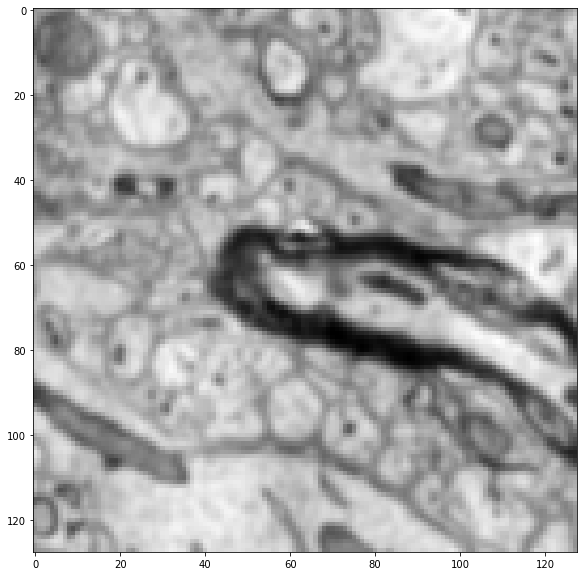

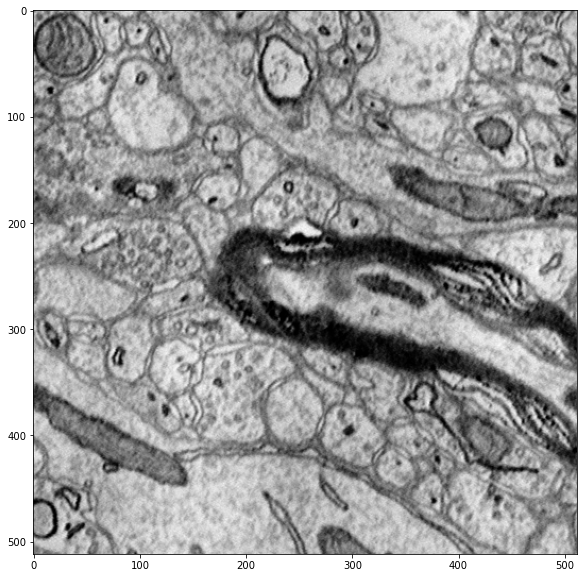

In [49]:
from src.datasets import extract_random_patches_from_folder

train_patches_wf, train_patches_gt = extract_random_patches_from_folder(
                                        hr_data_path=train_path, 
                                        lr_data_path=None, 
                                        filenames=train_filenames, 
                                        scale_factor=4, 
                                        crappifier_name='em_crappify', 
                                        lr_patch_shape=(128, 128), 
                                        num_patches=16)

X_train = np.expand_dims(train_patches_wf, axis=-1)
Y_train = np.expand_dims(train_patches_gt, axis=-1)

print('X_train')
print_info(X_train)
print('\n')

print('Y_train')
print_info(Y_train)

plot_images([X_train[0], Y_train[0]])

(262144,)
(262144,)


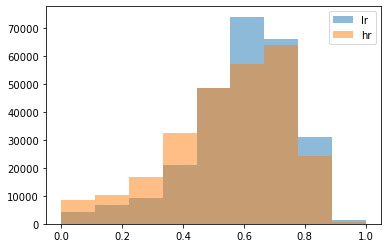

In [50]:
bins = np.linspace(-0, 1, 10)

print(np.repeat(X_train[0,:,:,0].flatten(), 16).shape)
print(Y_train[0,:,:,0].flatten().shape)

plt.hist(np.repeat(X_train[0,:,:,0].flatten(), 16), bins, alpha=0.5, label='lr')
plt.hist(Y_train[0,:,:,0].flatten(), bins, alpha=0.5, label='hr')
plt.legend(loc='upper right')
plt.show()

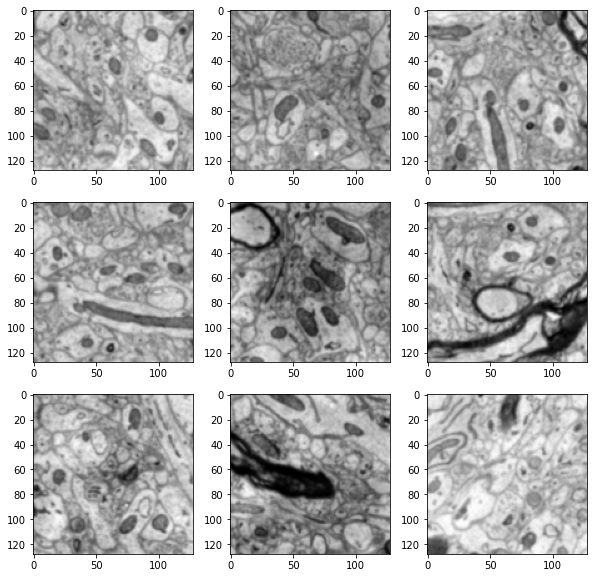

In [51]:
from src.datasets import get_train_val_generators 
batch_size = 4

train_generator, val_generator = get_train_val_generators(X_data=X_train,
                                                          Y_data=Y_train,
                                                          validation_split=0.1,
                                                          batch_size=batch_size,
                                                          show_examples=1,
                                                          rotation=True,
                                                          horizontal_flip=True,
                                                          vertical_flip=True)

In [52]:
for lr,hr in train_generator:
    print('LR')
    print_info(lr)
    print('\n')
    print('HR')
    print_info(hr)
    break

LR
Shape: (4, 128, 128, 1)
dtype: float32
Min: 0.007330136373639107
Min: 0.9921146035194397
Mean: 0.5812244415283203


HR
Shape: (4, 512, 512, 1)
dtype: float32
Min: 0.0
Min: 1.0
Mean: 0.6329106092453003


# Create a simple network (DFCAN for example)

In [53]:
library_name = 'tensorflow'

optimizer = 'Adam'

model_configuration = {'optim': {'early_stop':{'loss':'val_ssim_loss','mode':'max', 'patience':10},
                                 'adam':{'beta1':0.5,'beta2':0.9,'epsilon':1e-07},
                                 'adamax':{'beta1':0.5,'beta2':0.9,'epsilon':1e-07},
                                 'adamW':{'decay':0.004,'beta1':0.5,'beta2':0.9,'epsilon':1e-07},
                                 'sgd_momentum':0.9,
                                 'ReduceOnPlateau':{'monitor':'val_loss','factor':0.5,'patience':3},
                                 'MultiStepScheduler':{'lr_steps':[50000, 100000, 200000, 300000],
                                                       'lr_rate_decay':0.5}},
                       'rcan': {'num_filters':16,
                                'percp_coef': 1000},
                       'dfcan': {'n_ResGroup': 4, 'n_RCAB': 4},
                       'wdsr': {'num_res_blocks': 32},
                       'unet': {'init_channels': 16,
                                'depth': 4,
                                'upsample_method': 'SubpixelConv2D',
                                'maxpooling': False,
                                'percp_coef': 10},
                       'wgan': {'g_layers': 15,
                                'd_layers': 5,
                                'recloss': 100.0,
                                'lambda_gp':10},
                       'esrganplus': {'n_critic_steps':5},
                       'others': {'positional_encoding':False,
                                  'positional_encoding_channels':64}
                      }

from src.optimizer_scheduler_utils import select_optimizer, select_optimizer
optim = select_optimizer(library_name=library_name, optimizer_name=optimizer, 
                                learning_rate=0.001, check_point=None,
                                parameters=None, additional_configuration=model_configuration)
    
from src.model_utils import select_model
from src.utils import ssim_loss
model = select_model(model_name='dfcan', input_shape=X_train.shape, output_channels=Y_train.shape, 
                        scale_factor=4, model_configuration=model_configuration)

loss_funct = 'mean_absolute_error'
eval_metric = 'mean_squared_error'

model.compile(optimizer=optim, loss=loss_funct, metrics=[eval_metric, ssim_loss])

trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
totalParams = trainableParams + nonTrainableParams

print('Trainable parameteres: {} \nNon trainable parameters: {} \nTotal parameters: {}'.format(trainableParams, 
                                                                                                        nonTrainableParams, 
                                                                                                    totalParams))

Trainable parameteres: 2373889 
Non trainable parameters: 0.0 
Total parameters: 2373889.0


In [54]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_501 (Conv2D)             (None, 128, 128, 64) 640         input_10[0][0]                   
__________________________________________________________________________________________________
lambda_498 (Lambda)             (None, 128, 128, 64) 0           conv2d_501[0][0]                 
__________________________________________________________________________________________________
conv2d_502 (Conv2D)             (None, 128, 128, 64) 36928       lambda_498[0][0]                 
____________________________________________________________________________________________

In [62]:
from tensorflow.keras.callbacks import ModelCheckpoint as tf_ModelCheckpoint
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

epochs = 5

scheduler = 'OneCycle'

from src.optimizer_scheduler_utils import select_lr_schedule
lr_schedule = select_lr_schedule(library_name='tensorflow', lr_scheduler_name=scheduler, 
                                    data_len=X_train.shape[0]//batch_size, 
                                    number_of_epochs=epochs, learning_rate=0.001,
                                    monitor_loss=None, name=None, optimizer=None, frequency=None,
                                    additional_configuration=model_configuration)


model_checkpoint = tf_ModelCheckpoint(os.path.join('results', 'weights_best.h5'), 
                               monitor='val_loss',verbose=1, 
                               save_best_only=True, save_weights_only=True)

# callback for early stopping
earlystopper = EarlyStopping(monitor=model_configuration['optim']['early_stop']['loss'],
                 patience=model_configuration['optim']['early_stop']['patience'], 
                             min_delta=0.005, mode=model_configuration['optim']['early_stop']['mode'],
                             verbose=1, restore_best_weights=True)
        

import time
start = time.time()

history = model.fit(train_generator, validation_data=val_generator,
                  validation_steps=np.ceil((0.1*X_train.shape[0])/batch_size),
                  steps_per_epoch=np.ceil(X_train.shape[0]/batch_size),
                  epochs=epochs, 
                  callbacks=[lr_schedule, model_checkpoint, earlystopper])
    
dt = time.time() - start
mins, sec = divmod(dt, 60) 
hour, mins = divmod(mins, 60) 
print("\nTime elapsed:",hour, "hour(s)",mins,"min(s)",round(sec),"sec(s)\n")


Epoch 1/5
400/400 [==============================] - 180s 400ms/step - loss: 0.1554 - mean_squared_error: 0.0376 - val_loss: 0.1710 - val_mean_squared_error: 0.0457

Epoch 00001: val_loss improved from inf to 0.17096, saving model to results/weights_best.h5
Epoch 2/5
400/400 [==============================] - 157s 394ms/step - loss: 0.1576 - mean_squared_error: 0.0389 - val_loss: 0.1680 - val_mean_squared_error: 0.0450

Epoch 00002: val_loss improved from 0.17096 to 0.16800, saving model to results/weights_best.h5
Epoch 3/5
400/400 [==============================] - 157s 394ms/step - loss: 0.1558 - mean_squared_error: 0.0378 - val_loss: 0.1711 - val_mean_squared_error: 0.0482

Epoch 00003: val_loss did not improve from 0.16800
Epoch 4/5
400/400 [==============================] - 158s 394ms/step - loss: 0.1567 - mean_squared_error: 0.0384 - val_loss: 0.1688 - val_mean_squared_error: 0.0460

Epoch 00004: val_loss did not improve from 0.16800
Epoch 5/5
400/400 [===========================

# Make the prediction

In [69]:
lr_images, hr_images = extract_random_patches_from_folder(
                                hr_data_path=test_path, 
                                lr_data_path=None, 
                                filenames=test_filenames, 
                                scale_factor=4, 
                                crappifier_name='em_crappify', 
                                lr_patch_shape=None, 
                                num_patches=1)

hr_images = np.expand_dims(hr_images, axis=-1)
lr_images = np.expand_dims(lr_images, axis=-1)

print_info(hr_images)
print_info(lr_images)

Shape: (100, 1024, 1024, 1)
dtype: float32
Min: 0.0
Min: 1.0
Mean: 0.6235734820365906
Shape: (100, 256, 256, 1)
dtype: float32
Min: 0.0
Min: 1.0
Mean: 0.6515992879867554


In [70]:
drawn_lr_images, drawn_hr_images = extract_random_patches_from_folder(
                                hr_data_path=drawn_test_path, 
                                lr_data_path=None, 
                                filenames=drawn_test_filenames, 
                                scale_factor=4, 
                                crappifier_name='em_crappify', 
                                lr_patch_shape=None, 
                                num_patches=1)

drawn_hr_images = np.expand_dims(drawn_hr_images, axis=-1)
drawn_lr_images = np.expand_dims(drawn_lr_images, axis=-1)

print_info(drawn_hr_images)
print_info(drawn_lr_images)

Shape: (5, 1024, 1024, 1)
dtype: float32
Min: 0.0
Min: 1.0
Mean: 0.6628332138061523
Shape: (5, 256, 256, 1)
dtype: float32
Min: 0.0
Min: 1.0
Mean: 0.6781529188156128


In [71]:
optim = select_optimizer(library_name=library_name, optimizer_name=optimizer, 
                                learning_rate=0.001, check_point=None,
                                parameters=None, additional_configuration=model_configuration)

model = select_model(model_name='dfcan', input_shape=lr_images.shape,  
                     output_channels=1, scale_factor=4, model_configuration=model_configuration)

loss_funct = 'mean_absolute_error'
eval_metric = 'mean_squared_error'

model.compile(optimizer=optim, loss=loss_funct, metrics=[eval_metric])

# Load old weights
model.load_weights( os.path.join('results', 'weights_best.h5') )   

In [ ]:
test_predictions = model.predict(lr_images, batch_size=1)
print_info(test_predictions)

In [ ]:
drawn_test_predictions = model.predict(drawn_lr_images, batch_size=1)
print_info(drawn_test_predictions)

In [ ]:
plot_images([test_predictions[0], drawn_test_predictions[0]])